In [28]:
# Cell 1 - Imports & settings
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta

import ipywidgets as widgets
from IPython.display import display, clear_output 

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

# Folders
RECS_FOLDER = "recommendations"   # where hot_stocks_YYYYMMDD.csv are stored
PRICES_FOLDER = "daily_prices"    # optional - not required here
OUTPUT_FOLDER = "reports"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Parameters
MIN_DAYS_HISTORY = 30           # minimum days to consider for forward-return analysis
PERSISTENT_DAYS = 180           # window for persistent top calculation (e.g., 6 months ~ 180 days)
STREAK_THRESHOLD = 3            # >= this many consecutive days => streak
TOP_N_PERSISTENT = 10           # final top N list
FORWARD_HORIZONS = [1, 5, 20]   # forward returns in trading days to evaluate (1-day, 5-day, 20-day)


In [29]:
# Cell 2 - Load recommendation files
files = sorted(glob.glob(os.path.join(RECS_FOLDER, "hot_stocks_*.csv")))
if not files:
    raise FileNotFoundError(f"No files found in {RECS_FOLDER}. Run your daily scanner first.")

print(f"Found {len(files)} recommendation files (sample):", files[:5])

# Load and tag with date (YYYYMMDD)
dfs = []
for f in files:
    df = pd.read_csv(f)
    # extract date part from filename
    date_tag = os.path.basename(f).replace("hot_stocks_", "").replace(".csv", "")
    # ensure symbol column name
    if 'symbol' not in df.columns and 'Symbol' in df.columns:
        df = df.rename(columns={'Symbol':'symbol'})
    df['date'] = pd.to_datetime(date_tag, format="%Y%m%d%H%M%S")
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True, sort=False)
print("Loaded rows:", len(full_df))
full_df.head()


Found 8 recommendation files (sample): ['recommendations\\hot_stocks_20251115174433.csv', 'recommendations\\hot_stocks_20251117182242.csv', 'recommendations\\hot_stocks_20251117215705.csv', 'recommendations\\hot_stocks_20251117220812.csv', 'recommendations\\hot_stocks_20251118083059.csv']
Loaded rows: 400


,symbol,regularMarketPrice,regularMarketChangePercent,regularMarketVolume,averageDailyVolume3Month,marketCap,VolumeSpike,MomentumScore,VolumeScore,VolatilityScore,TrendScore,HotScore,date
0,CDTX,217.71,105.40600,17287415.0,872168.0,6.844666e+09,19.821198,1.000000,1.000000,1.000000,0.971787,0.997179,2025-11-15 17:44:33
1,SRRK,37.41,24.40970,6996750.0,2528325.0,3.596121e+09,2.767346,0.996865,0.962382,0.949843,0.761755,0.951881,2025-11-15 17:44:33
2,ABVX,110.39,9.40535,2409287.0,1075398.0,8.591534e+09,2.240368,0.968652,0.924765,0.968652,0.943574,0.950784,2025-11-15 17:44:33
3,LGN,40.27,20.85830,2813196.0,1162546.0,3.504975e+09,2.419858,0.990596,0.934169,0.940439,0.874608,0.949216,2025-11-15 17:44:33
4,DASH,206.96,6.01916,11452141.0,3701549.0,8.413522e+10,3.093878,0.921630,0.968652,0.981191,0.912226,0.949060,2025-11-15 17:44:33


In [30]:
# Cell 3 - Clean and ensure numeric columns
cols_num = ['regularMarketPrice','regularMarketChangePercent','regularMarketVolume',
            'averageDailyVolume3Month','marketCap','HotScore','VolumeSpike',
            'MomentumScore','VolumeScore','VolatilityScore','TrendScore']

for c in cols_num:
    if c in full_df.columns:
        full_df[c] = pd.to_numeric(full_df[c], errors='coerce')

# Keep only relevant columns (some older files may differ)
keep_cols = ['symbol','date','HotScore','regularMarketPrice','regularMarketChangePercent',
             'VolumeSpike','averageDailyVolume3Month','marketCap']
for c in keep_cols:
    if c not in full_df.columns:
        full_df[c] = np.nan

full_df = full_df[keep_cols]
full_df['symbol'] = full_df['symbol'].astype(str).str.upper()

# Sort by date ascending
full_df = full_df.sort_values(['date','symbol']).reset_index(drop=True)
print("Unique dates:", full_df['date'].nunique(), "Unique symbols:", full_df['symbol'].nunique())


Unique dates: 8 Unique symbols: 136


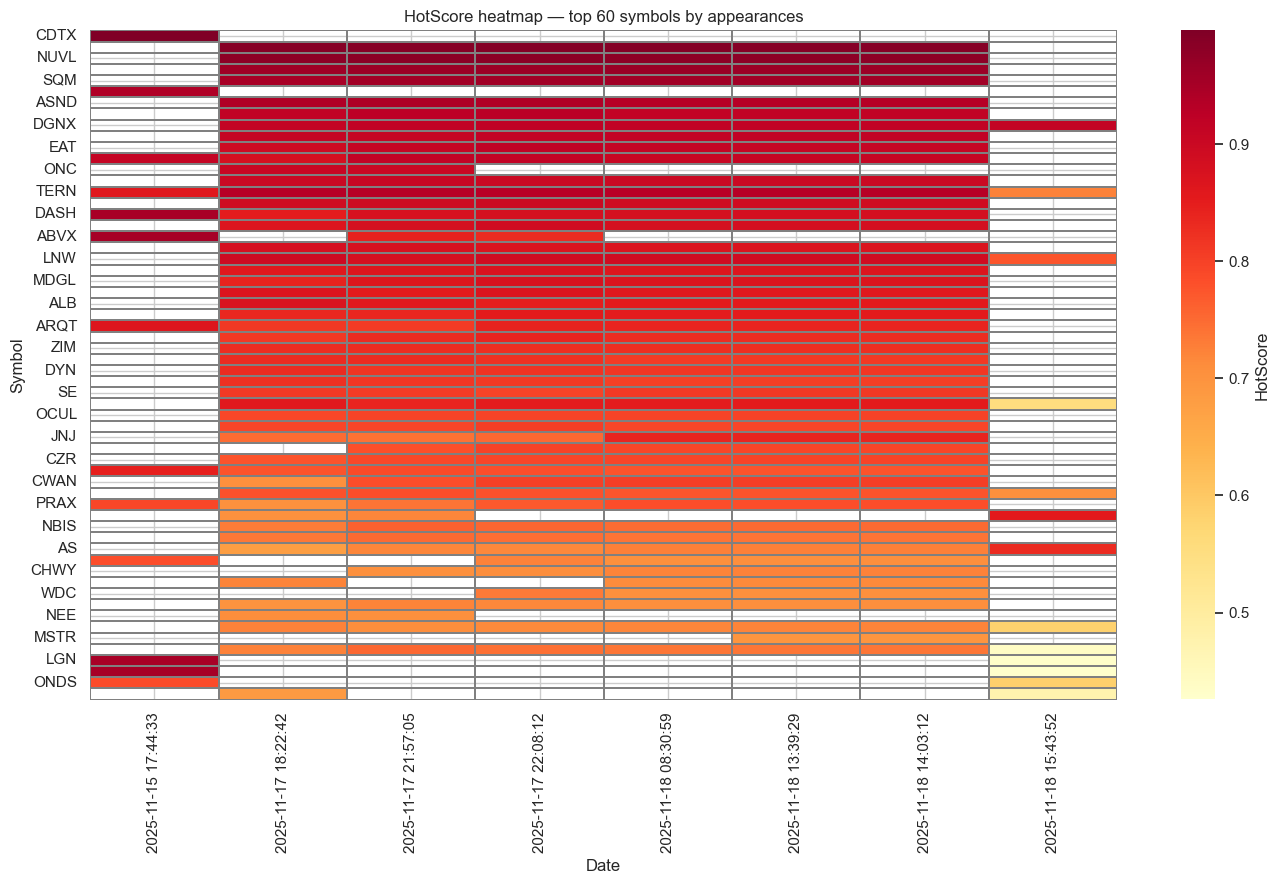

In [31]:
# Cell 4 - Heatmap of HotScore over time
# Choose symbols to show: top K that appear most often or top average HotScore
TOP_SYMBOLS_PLOT = 60  # keep manageable for heatmap

# pick top symbols by appearances
top_symbols = full_df['symbol'].value_counts().head(TOP_SYMBOLS_PLOT).index.tolist()

# pivot
pivot = full_df[full_df['symbol'].isin(top_symbols)].pivot_table(
    index='symbol', columns='date', values='HotScore', aggfunc='mean'
)

# Sort symbols by average hotscore
pivot = pivot.assign(avg=pivot.mean(axis=1)).sort_values('avg', ascending=False).drop(columns='avg')

# Plot
plt.figure(figsize=(14, max(6, 0.15*len(pivot))))
sns.heatmap(pivot, cmap='YlOrRd', linewidths=0.3, linecolor='gray', cbar_kws={'label':'HotScore'})
plt.title(f"HotScore heatmap — top {len(pivot)} symbols by appearances")
plt.xlabel("Date")
plt.ylabel("Symbol")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, f"heatmap_hotscore_{datetime.now().strftime('%Y%m%d')}.png"))
plt.show()


In [32]:
# Cell 5 - Streak detection (consecutive appearances)
# We consider a symbol 'appeared' on a date if it exists in that day's top50 (regardless of HotScore)
# Build presence matrix (symbol x date) boolean
dates = sorted(full_df['date'].unique())
symbols = sorted(full_df['symbol'].unique())

presence = pd.DataFrame(0, index=symbols, columns=dates)
for d in dates:
    syms = full_df.loc[full_df['date']==d, 'symbol'].unique()
    presence.loc[syms, d] = 1

# compute consecutive streaks ending on each date
def consecutive_streak(series):
    # series: 0/1 values ordered by date ascending
    arr = series.values
    # compute run lengths
    streaks = np.zeros_like(arr, dtype=int)
    current = 0
    for i, v in enumerate(arr):
        if v == 1:
            current += 1
            streaks[i] = current
        else:
            current = 0
            streaks[i] = 0
    return streaks

streaks = presence.apply(consecutive_streak, axis=1, result_type='expand')
streaks.columns = dates

# current streak for each symbol (ending on latest date)
latest_date = dates[-1]
current_streak = streaks[latest_date].sort_values(ascending=False)
streak_df = current_streak.reset_index().rename(columns={'index':'symbol', latest_date:'current_streak'})
streak_df = streak_df[streak_df['current_streak']>0]

# symbols with streak >= threshold
streak_symbols = streak_df[streak_df['current_streak'] >= STREAK_THRESHOLD]
print(f"Symbols with current streak >= {STREAK_THRESHOLD} days:", len(streak_symbols))
streak_symbols.head(10)


Symbols with current streak >= 3 days: 9


,symbol,current_streak
0,TERN,8
1,GOOGL,7
2,QUBT,7
3,MTSR,7
4,DGNX,7
5,LNW,7
6,AS,7
7,PACS,7
8,TSLA,7


In [33]:
# Cell 6 - Persistent top list over last PERSISTENT_DAYS
window_end = full_df['date'].max()
window_start = window_end - pd.Timedelta(days=PERSISTENT_DAYS)

mask = (full_df['date'] >= window_start) & (full_df['date'] <= window_end)
window_df = full_df.loc[mask].copy()

# compute stats per symbol: appearances, avg HotScore, median HotScore
stats = window_df.groupby('symbol').agg(
    appearances = ('date','nunique'),
    avg_HotScore = ('HotScore','mean'),
    median_HotScore = ('HotScore','median')
).sort_values(['appearances','avg_HotScore'], ascending=False)

# pick top N persistent by appearances and avg score
persistent_top = stats.sort_values(['appearances','avg_HotScore'], ascending=False).head(TOP_N_PERSISTENT)
print(f"Persistent top {TOP_N_PERSISTENT} (window {window_start.date()} to {window_end.date()}):")
persistent_top


Persistent top 10 (window 2025-05-22 to 2025-11-18):


,appearances,avg_HotScore,median_HotScore
symbol,,,
TERN,8,0.895531,0.929781
PACS,7,0.964222,0.964537
DGNX,7,0.917006,0.917025
SNDK,7,0.906901,0.908423
DASH,7,0.887388,0.883333
LNW,7,0.873410,0.890412
ARQT,7,0.835699,0.840860
GOOGL,7,0.808503,0.851246
FIGR,7,0.789280,0.776654


In [34]:
# Cell 7 - Candidate generation and technical checks
# Candidates = union of:
#  - symbols with current streak >= STREAK_THRESHOLD
#  - persistent_top symbols
candidates = set(streak_symbols['symbol'].tolist()) | set(persistent_top.index.tolist())
candidates = sorted(candidates)
print("Candidates to analyze:", len(candidates), candidates[:30])

def technical_checks(symbol):
    try:
        hist = yf.download(symbol, period="1y", interval="1d", progress=False, auto_adjust=True)
        if hist.empty:
            return None
        
        close = hist['Close']
        vol = hist['Volume'] if 'Volume' in hist.columns else None

        if len(close) < 50:
            return None

        price = float(close.iloc[-1])
        ma50 = float(close.rolling(50).mean().iloc[-1])
        ma200 = float(close.rolling(200).mean().iloc[-1]) if len(close) >= 200 else np.nan
        
        ret30 = float(((price / close.shift(30).iloc[-1]) - 1) * 100) if len(close) >= 30 else np.nan

        vol20 = float(close.pct_change().rolling(20).std().iloc[-1] * np.sqrt(252) * 100) if len(close) >= 20 else np.nan
        
        avgvol = float(vol.rolling(20).mean().iloc[-1]) if vol is not None else np.nan

        return {
            'symbol': symbol,
            'price': price,
            'ma50': ma50,
            'ma200': ma200,
            'ret30_pct': ret30,
            'vol20_ann_pct': vol20,
            'avgvol': avgvol
        }

    except Exception as e:
        print("Error technical checks", symbol, e)
        return None


tech_rows = []
for s in candidates:
    r = technical_checks(s)
    if r:
        tech_rows.append(r)

tech_df = pd.DataFrame(tech_rows).set_index('symbol')
tech_df.drop( columns=['ma200', 'ret30_pct' , 'vol20_ann_pct'], inplace=True) 
tech_df.head()


Candidates to analyze: 13 ['ARQT', 'AS', 'DASH', 'DGNX', 'FIGR', 'GOOGL', 'LNW', 'MTSR', 'PACS', 'QUBT', 'SNDK', 'TERN', 'TSLA']


C:\Users\a73s\AppData\Local\Temp\ipykernel_39464\3442960333.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(close.iloc[-1])
C:\Users\a73s\AppData\Local\Temp\ipykernel_39464\3442960333.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ma50 = float(close.rolling(50).mean().iloc[-1])
C:\Users\a73s\AppData\Local\Temp\ipykernel_39464\3442960333.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ma200 = float(close.rolling(200).mean().iloc[-1]) if len(close) >= 200 else np.nan
C:\Users\a73s\AppData\Local\Temp\ipykernel_39464\3442960333.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) i

,price,ma50,avgvol
symbol,,,
ARQT,25.879999,20.916100,2942731.85
AS,32.680000,33.016600,4905816.05
DASH,208.240005,252.374799,6053688.75
DGNX,14.850000,16.491200,893152.25
GOOGL,279.540009,259.058600,33423154.60


In [39]:
# Cell 8 - Backtest forward returns for candidate symbols
# For each date a symbol appeared in top50, compute forward returns at horizons.
# We'll aggregate mean forward returns per symbol.

def forward_returns_for_symbol(symbol, appear_dates, horizons=[1,5,20]):
    # fetch price series a bit wider to compute forward returns
    hist = yf.download(symbol, period="2y", interval="1d", progress=False, auto_adjust=True)
    if hist.empty:
        return None
    close = hist['Close']
    results = []
    for date in appear_dates:
        # find the trading date >= date (in case of weekends)
        date_str = pd.to_datetime(date).strftime("%Y-%m-%d")
        if date_str not in close.index.astype(str):
            # find next trading date after date
            idx = close.index.searchsorted(pd.to_datetime(date))
            if idx >= len(close): 
                continue
        else:
            idx = close.index.get_loc(pd.to_datetime(date_str))
        base_price = close.iloc[idx]
        row = {'date': date}
        for h in horizons:
            future_idx = idx + h
            if future_idx < len(close):
                future_price = close.iloc[future_idx]
                row[f"ret_fwd_{h}d"] = (future_price/base_price - 1) * 100
            else:
                row[f"ret_fwd_{h}d"] = np.nan
        results.append(row)
    if not results:
        return None
    return pd.DataFrame(results)

# Aggregate for all candidates (this may take time for many symbols)
agg_rows = []
for s in candidates:
    dates_s = full_df.loc[full_df['symbol']==s, 'date'].dt.strftime("%Y-%m-%d").unique().tolist()
    df_f = forward_returns_for_symbol(s, dates_s, horizons=FORWARD_HORIZONS)
    if df_f is None:
        continue
    # mean forward returns per symbol
    mean_row = {'symbol': s}
    for h in FORWARD_HORIZONS:
        mean_row[f"mean_ret_fwd_{h}d"] = df_f[f"ret_fwd_{h}d"].mean(skipna=True)
    mean_row['appearances'] = len(dates_s)
    agg_rows.append(mean_row)

agg_df = pd.DataFrame(agg_rows).set_index('symbol')
agg_df = agg_df.sort_values(f"mean_ret_fwd_{FORWARD_HORIZONS[1]}d", ascending=False)  # sort by 5d mean
agg_df.drop( columns=['mean_ret_fwd_5d', 'mean_ret_fwd_20d'], inplace=True)
agg_df.head(20)


C:\Users\a73s\AppData\Local\Temp\ipykernel_39464\3831491995.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_row[f"mean_ret_fwd_{h}d"] = df_f[f"ret_fwd_{h}d"].mean(skipna=True)
C:\Users\a73s\AppData\Local\Temp\ipykernel_39464\3831491995.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_row[f"mean_ret_fwd_{h}d"] = df_f[f"ret_fwd_{h}d"].mean(skipna=True)
C:\Users\a73s\AppData\Local\Temp\ipykernel_39464\3831491995.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_row[f"mean_ret_fwd_{h}d"] = df_f[f"ret_fwd_{h}d"].mean(skipna=True)
C:\Users\a73s\AppData\Local\Temp\ipykernel_39464\3831491995.py:46: FutureWarning: Calling float on a single element Series is deprecated and will

,mean_ret_fwd_1d,appearances
symbol,,
ARQT,-0.917080,3
AS,6.599482,2
DASH,-0.417750,3
DGNX,11.258276,2
FIGR,-6.818184,3
GOOGL,-1.371835,2
LNW,NaN,2
PACS,-7.582804,2
QUBT,2.478260,2


In [36]:
def build_trade_suggestions(tech_df, agg_df, persistent_top, output_folder="recommendations"):

    os.makedirs(output_folder, exist_ok=True)

    # Merge indices
    all_symbols = sorted(set(tech_df.index) | set(agg_df.index) | set(persistent_top.index))
    rec = pd.DataFrame(index=all_symbols)

    # Join dataframes safely
    rec = rec.join(tech_df, how='left')
    rec = rec.join(agg_df, how='left')
    rec = rec.join(persistent_top[['appearances','avg_HotScore']].rename(
        columns={'appearances': 'appearances_persistent'}
    ), how='left')

    # Ensure numeric columns exist
    for col in ['price','ma50','mean_ret_fwd_5d','appearances_persistent','avg_HotScore']:
        if col not in rec.columns:
            rec[col] = 0
        else:
            rec[col] = pd.to_numeric(rec[col], errors='coerce').fillna(0)

    # Initialize rule_score
    rec['rule_score'] = 0

    # Rule 1: Price above MA50
    rec['rule_score'] += (rec['price'] > rec['ma50']).astype(int) * 2

    # Rule 2: Positive mean forward 5-day returns
    rec['rule_score'] += (rec['mean_ret_fwd_5d'] > 0).astype(int) * 2

    # Rule 3: Persistent appearances >= 3
    rec['rule_score'] += (rec['appearances_persistent'] >= 3).astype(int) * 1

    # Rule 4: Avg HotScore above median
    median_hot = rec['avg_HotScore'].median()
    rec['rule_score'] += (rec['avg_HotScore'] > median_hot).astype(int) * 1

    # Sort
    rec = rec.sort_values(['rule_score','mean_ret_fwd_5d'], ascending=[False, False])

    # Save
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    rec_file = os.path.join(output_folder, f"trade_suggestions_{timestamp}.csv")
    rec.to_csv(rec_file)
    print(f"Saved trade suggestions: {rec_file}")

    return rec, rec_file


In [ ]:
rec_df, rec_file = build_trade_suggestions(tech_df, agg_df, persistent_top, output_folder=RECS_FOLDER)
rec_df.head(5) 




Saved trade suggestions: recommendations\trade_suggestions_20251118161446.csv


,price,ma50,avgvol,mean_ret_fwd_1d,appearances,appearances_persistent,avg_HotScore,mean_ret_fwd_5d,rule_score
LNW,87.000000,81.909000,4060665.20,NaN,2.0,7.0,0.873410,0,4
PACS,14.490000,12.437800,1178798.95,-7.582804,2.0,7.0,0.964222,0,4
SNDK,233.695007,155.327901,11820635.60,-10.775541,3.0,7.0,0.906901,0,4
TERN,26.709999,10.867000,5078173.45,3.990612,3.0,8.0,0.895531,0,4
ARQT,25.879999,20.916100,2942731.85,-0.917080,3.0,7.0,0.835699,0,3


In [38]:
import ipywidgets as widgets

top_suggested = rec_df.head(10).index.tolist()

# UI widgets
symbol_dropdown = widgets.Dropdown(
    options=top_suggested,
    value=top_suggested[0],
    description='Symbol:',
    style={'description_width': '80px'},
    layout=widgets.Layout(width='300px')
)

plot_button = widgets.Button(
    description='Plot Chart',
    button_style='success',
    tooltip='Generate chart for selected symbol',
    layout=widgets.Layout(width='200px')
)

output_area = widgets.Output()

def on_plot_button_clicked(b):
    with output_area:
        clear_output(wait=True)

        s = symbol_dropdown.value
        print(f"Loading chart for {s}...")

        try:
            h = yf.download(s, period="6mo", interval="1d", progress=False, auto_adjust=True)

            if h.empty:
                print("No data available.")
                return

            close = h['Close']
            ma50 = close.rolling(50).mean()

            plt.figure(figsize=(10, 4))
            plt.plot(close.index, close, label=f"{s} Close")
            plt.plot(ma50.index, ma50, label='MA50', linestyle='--')
            plt.title(f"{s} — 6-month Price & MA50")
            plt.xlabel("Date")
            plt.ylabel("Price")
            plt.grid(True)
            plt.legend()
            plt.show()

        except Exception as e:
            print("Plot error:", e)

plot_button.on_click(on_plot_button_clicked)

# Display UI
display(widgets.VBox([symbol_dropdown, plot_button, output_area]))
